<a href="https://colab.research.google.com/github/C242-PS253-Capstone-Team/ML_Face_Shape_Recognition/blob/rifal/ML_Model_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
pip install --upgrade tensorflow keras

In [ ]:
pip install mtcnn

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import shutil
import cv2
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import mtcnn

from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation, RandomBrightness
from keras.utils import plot_model
from matplotlib import pyplot as plt
from mtcnn import MTCNN
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications.mobilenet import preprocess_input

# EDA

#### Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/MyDrive/Dataset/extracted_faces/train'
# val_dr = '/content/drive/MyDrive/Dataset/extracted_faces/test'
# test_dir = '/content/drive/MyDrive/Dataset/extracted_faces/real_test'

# Path ke folder test asli
test_dir = '/content/drive/MyDrive/Dataset/extracted_faces/test'

# Path ke folder validation dan test baru
val_dir = '/content/drive/MyDrive/Dataset/extracted_faces/validation'
real_test_dir = '/content/drive/MyDrive/Dataset/extracted_faces/real_test'

In [ ]:
# Buat folder jika belum ada
os.makedirs(val_dir, exist_ok=True)
os.makedirs(real_test_dir, exist_ok=True)

In [ ]:
import random
from collections import Counter

# Split ratio (misalnya 50% untuk validation, 50% untuk test)
val_ratio = 0.5

for class_name in os.listdir(test_dir):
    class_dir = os.path.join(test_dir, class_name)
    images = os.listdir(class_dir)
    random.shuffle(images)

    val_split_index = int(len(images) * val_ratio)

    # Pindahkan file ke folder validation
    for image in images[:val_split_index]:
        src = os.path.join(class_dir, image)
        dst = os.path.join(val_dir, class_name, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.move(src, dst)

    # Pindahkan file ke folder test baru
    for image in images[val_split_index:]:
        src = os.path.join(class_dir, image)
        dst = os.path.join(test_dir, class_name, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.move(src, dst)

In [ ]:
def check_distribution(dir_path):
    class_counts = Counter()
    for class_name in os.listdir(dir_path):
        class_dir = os.path.join(dir_path, class_name)
        class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

print("Distribusi data di folder train:", check_distribution(train_dr))
print("Distribusi data di folder validation:", check_distribution(val_dir))
print("Distribusi data di folder test baru:", check_distribution(test_dir))

Distribusi data di folder train: Counter({'Oblong': 809, 'Round': 800, 'Oval': 800, 'Heart': 799, 'Square': 798})
Distribusi data di folder validation: Counter({'Heart': 105, 'Oblong': 100, 'Square': 100, 'Oval': 100, 'Round': 100})
Distribusi data di folder test baru: Counter({'Heart': 105, 'Oblong': 100, 'Square': 100, 'Oval': 100, 'Round': 100})


In [ ]:
# Mengurutkan folder di training directory
train_folders = [folder for folder in class_names if folder in os.listdir(train_dr)]

# Mengurutkan folder di validation directory
val_folders = [folder for folder in class_names if folder in os.listdir(val_dr)]

In [ ]:
print("Training directory contents:", train_folders)
print("Validation directory contents:", val_folders)

Training directory contents: ['Oblong', 'Heart', 'Round', 'Square', 'Oval']
Validation directory contents: ['Oblong', 'Heart', 'Round', 'Square', 'Oval']


In [ ]:
# Inisialisasi detektor MTCNN
detector = MTCNN()

def extract_face(img, target_size=(224,224)):
    '''this function extracts the face from different images by
    1) finds the facial bounding box
    2) slightly expands top & bottom boundaries to include the whole face
    3) crop into a square shape
    4) resize to target image size for modelling
    5) if the facial bounding box in step 1 is not found, image will be cropped & resized to 224x224 square'''

    # 1. deteksi wajah pada gambar
    results = detector.detect_faces(img)
    if results == []:  # jika wajah tidak terdeteksi, crop & resize dengan mempertahankan rasio aspek
        new_face = crop_and_resize(img, target_w=224, target_h=224)
    else:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1 + width, y1 + height
        face = img[y1:y2, x1:x2]  # wajah dari bounding box sebelum ekspansi bbox

        # 2. memperbesar bagian atas dan bawah bounding box sebanyak 10 pixel untuk memastikan seluruh wajah terekstrak
        adj_h = 10
        new_y1 = max(0, y1 - adj_h)
        new_y2 = min(img.shape[0], y1 + height + adj_h)
        new_height = new_y2 - new_y1

        # 3. crop gambar menjadi bentuk persegi
        adj_w = int((new_height - width) / 2)
        new_x1 = max(0, x1 - adj_w)
        new_x2 = min(img.shape[1], x2 + adj_w)
        new_face = img[new_y1:new_y2, new_x1:new_x2]  # crop wajah ke bentuk persegi

    # 4. resize gambar ke ukuran target
    sqr_img = cv2.resize(new_face, target_size)
    return sqr_img

In [ ]:
def process_and_save_images_optimized(class_path, output_class_path, batch_size=50):
    import gc
    files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    total_files = len(files)

    for i in range(0, total_files, batch_size):
        batch_files = files[i:i + batch_size]
        for item in batch_files:
            item_path = os.path.join(class_path, item)
            extracted_face = None
            try:
                img = cv2.imread(item_path, cv2.IMREAD_REDUCED_COLOR_2)  # Optimized reading
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                extracted_face = extract_face(img_rgb)

                if extracted_face is not None:
                    output_file_path = os.path.join(output_class_path, item)
                    cv2.imwrite(output_file_path, cv2.cvtColor(extracted_face, cv2.COLOR_RGB2BGR))
                    print(f"Successfully processed and saved: {output_file_path}")
                else:
                    print(f"Face not detected in: {item_path}")
            except Exception as e:
                print(f"Error processing image {item_path}: {e}")
            finally:
                if extracted_face is not None:
                    del img, extracted_face  # Free memory
                gc.collect()

        print(f"Processed batch {i // batch_size + 1}/{(total_files + batch_size - 1) // batch_size}")



# --- Cara menggunakan fungsi yang dimodifikasi ---
# Tentukan path dataset dan output
dataset_path = '/content/drive/MyDrive/Dataset_Capstone/Kaggle/combined_data/combined_train/Round'
output_path = '/content/drive/MyDrive/Dataset_Capstone/extracted_faces/train/Round'

# Ensure the output directory exists
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Directly call process_and_save_images with the dataset path
process_and_save_images_optimized(dataset_path, output_path)

# Lakukan hal yang sama untuk dataset validation

In [ ]:
# Menampilkan urutan folder
print("Urutan folder di dalam", train_dr + ":")
for i, folder_name in enumerate(train_folders):
  print(f"{i+1}. {folder_name}")

# Menampilkan urutan folder
print("Urutan folder di dalam", val_dr + ":")
for i, folder_name in enumerate(val_folders):
  print(f"{i+1}. {folder_name}")

Urutan folder di dalam /content/drive/MyDrive/Dataset/extracted_faces/train:
1. Oblong
2. Heart
3. Round
4. Square
5. Oval
Urutan folder di dalam /content/drive/MyDrive/Dataset/extracted_faces/test:
1. Oblong
2. Heart
3. Round
4. Square
5. Oval


In [ ]:
class_names = ['Oblong', 'Heart', 'Round', 'Square', 'Oval']

In [ ]:
def create_datasets():
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        seed=0,
        batch_size=32,
        label_mode='categorical',
        image_size=(224, 224),
        shuffle=True
    )

    validation_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        seed=0,
        batch_size=32,
        label_mode='categorical',
        image_size=(224, 224),
        shuffle=False
    )

    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        seed=0,
        batch_size=32,
        label_mode='categorical',
        image_size=(224, 224),
        shuffle=False
    )

    return train_ds, validation_ds, test_ds

In [ ]:
# Create datasets with or without data augmentation
train_ds, validation_ds, test_ds = create_datasets()

Found 4006 files belonging to 5 classes.
Found 505 files belonging to 5 classes.
Found 505 files belonging to 5 classes.


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

IMG_SHAPE = (224, 224, 3)

# base_model = MobileNetV2(
#     weights='imagenet',
#     include_top=False,
#     input_shape=IMG_SHAPE
# )

# tuning_layer_name = 'block_15_expand'
# tuning_layer = base_model.get_layer(tuning_layer_name)
# tuning_index = base_model.layers.index(tuning_layer)

# # Membekukan semua layer sebelum tuning_layer
# for layer in base_model.layers[:tuning_index]:
#     layer.trainable = False

base_model = VGG16(input_shape=IMG_SHAPE,
                   include_top=False,
                   weights='imagenet')

for layer in base_model.layers:
  layer.trainable = False

# Layer augmentasi
data_augmentation = tf.keras.Sequential([
    Rescaling(1./255),
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.1),
    RandomZoom(0.2),
    RandomContrast(0.3),
    RandomTranslation(0.1, 0.1),
], name='data_augmentation')

In [ ]:
model = Sequential([
    data_augmentation,
    base_model,
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
learning_rate = 0.0001

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy']>0.95:
            self.model.stop_training = True
            print("\nReached 95% accuracy so cancelling training!")

early_stopping_callback = EarlyStoppingCallback()

In [ ]:
EPOCH = 70
BATCH_SIZE = 32

history = model.fit(
    train_ds,
    epochs=EPOCH,
    verbose=1,
    validation_data=validation_ds,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping_callback]
)

Epoch 1/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 92s 678ms/step - accuracy: 0.2340 - loss: 1.6695 - val_accuracy: 0.3109 - val_loss: 1.5636
Epoch 2/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 75s 179ms/step - accuracy: 0.2708 - loss: 1.5678 - val_accuracy: 0.2812 - val_loss: 1.5393
Epoch 3/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 181ms/step - accuracy: 0.3118 - loss: 1.5290 - val_accuracy: 0.3208 - val_loss: 1.5049
Epoch 4/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 22s 173ms/step - accuracy: 0.3419 - loss: 1.4935 - val_accuracy: 0.2772 - val_loss: 1.5236
Epoch 5/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.3811 - loss: 1.4442 - val_accuracy: 0.3129 - val_loss: 1.4961
Epoch 6/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 45s 203ms/step - accuracy: 0.3895 - loss: 1.4195 - val_accuracy: 0.2911 - val_loss: 1.5683
Epoch 7/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 37s 174ms/step - accuracy: 0.3877 - loss: 1.4119 - val_accuracy: 0.3248 - val_loss: 1.4803
Epoch 8/70
126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 182ms/step - accuracy: 0.4179 - loss: 1

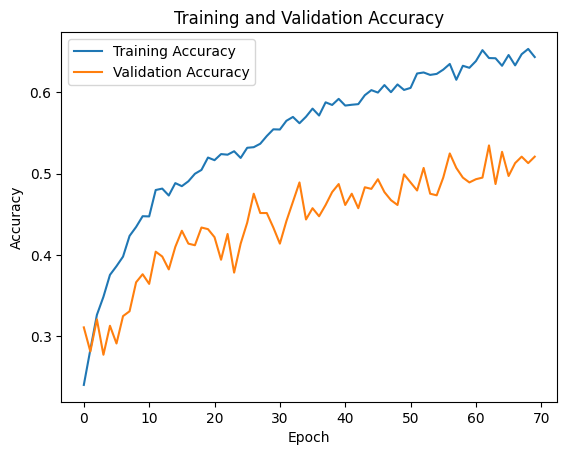

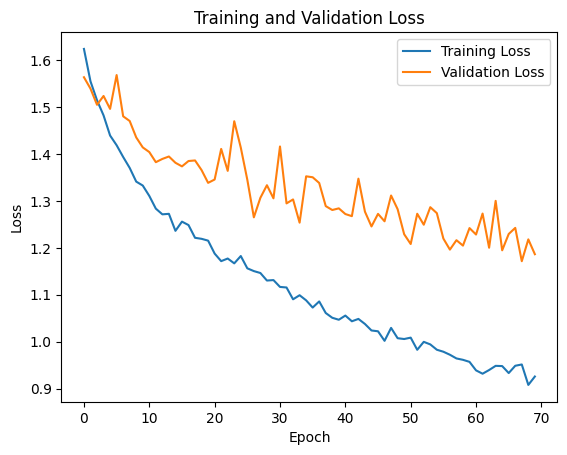

In [ ]:
# Visualisasi akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Visualisasi loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Dapatkan prediksi untuk data testing
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)

# Dapatkan label sebenarnya untuk data testing
y_true = np.concatenate([y for x, y in validation_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

# Hitung dan print metrik
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')



16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step


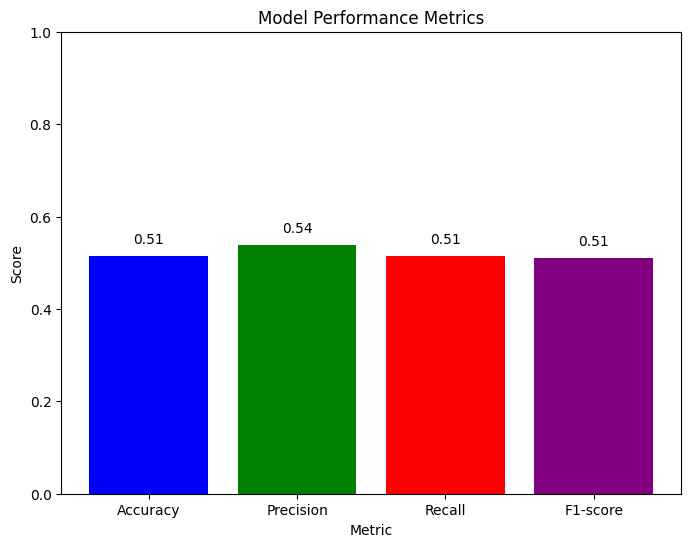

In [ ]:
# Data metrik
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

# Membuat bar chart
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.title('Model Performance Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim([0, 1])  # Mengatur batas sumbu y antara 0 dan 1

# Menambahkan label nilai di atas setiap bar
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

plt.show()

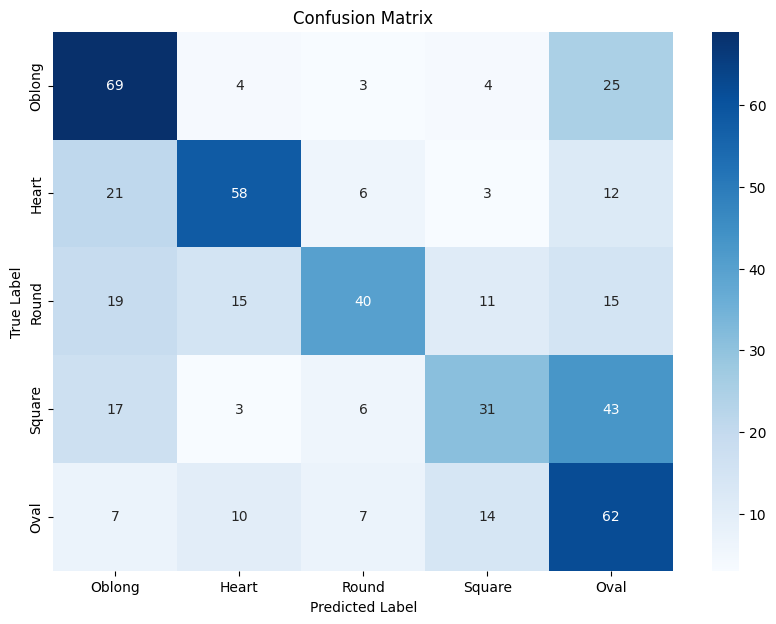

In [ ]:
# Buat dan tampilkan confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
EPOCH = 70
BATCH_SIZE = 32

history = model.fit(
    train_ds,
    epochs=EPOCH,
    verbose=1,
    validation_data=validation_ds,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping_callback]
)

In [ ]:
model.save('/content/drive/MyDrive/Model/Model_V4.h5')

In [ ]:
model_path = '/content/drive/MyDrive/Model_V3.keras'
tf.keras.models.save_model(
    model, filepath=model_path, overwrite=True, include_optimizer=True, save_format=None)

## Convert to tfLite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('/content/drive/MyDrive/Dataset/Model/Model_V4.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpnghk5zwa'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_132')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  138873206268752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138873206267696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138873207535600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138873207521344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138873207535248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138873207529440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138873207524160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138873207532080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138873240544432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138873207534192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1388732075

In [ ]:
history_1 = model.fit(
    train_ds,
    epochs=50,
    verbose=1,
    validation_data=validation_ds,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping_callback]
)

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 27s 210ms/step - accuracy: 0.6526 - loss: 0.9096 - val_accuracy: 0.4891 - val_loss: 1.3397
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 180ms/step - accuracy: 0.6610 - loss: 0.9055 - val_accuracy: 0.5089 - val_loss: 1.2088
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 40s 173ms/step - accuracy: 0.6588 - loss: 0.9032 - val_accuracy: 0.5327 - val_loss: 1.1937
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 181ms/step - accuracy: 0.6697 - loss: 0.8828 - val_accuracy: 0.5228 - val_loss: 1.2344
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 43s 195ms/step - accuracy: 0.6547 - loss: 0.9112 - val_accuracy: 0.4871 - val_loss: 1.2840
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - accuracy: 0.6747 - loss: 0.8713 - val_accuracy: 0.4891 - val_loss: 1.3445
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 22s 176ms/step - accuracy: 0.6530 - loss: 0.8907 - val_accuracy: 0.5069 - val_loss: 1.2481
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.6749 - loss: 0

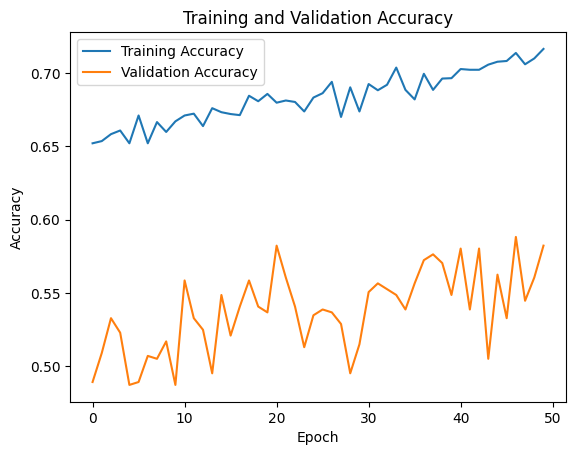

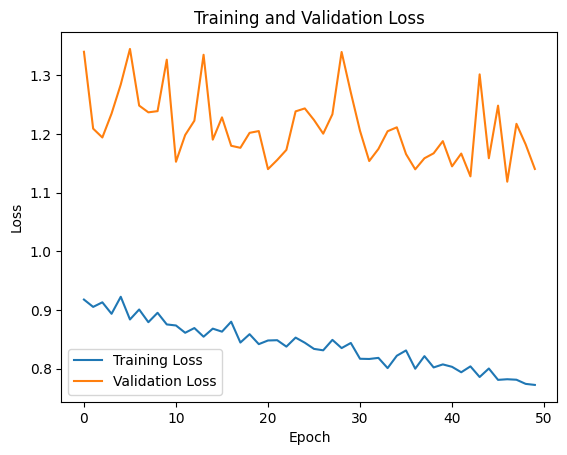

In [ ]:
# Visualisasi akurasi
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Visualisasi loss
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Dapatkan prediksi untuk data testing
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)

# Dapatkan label sebenarnya untuk data testing
y_true = np.concatenate([y for x, y in validation_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

# Hitung dan print metrik
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step


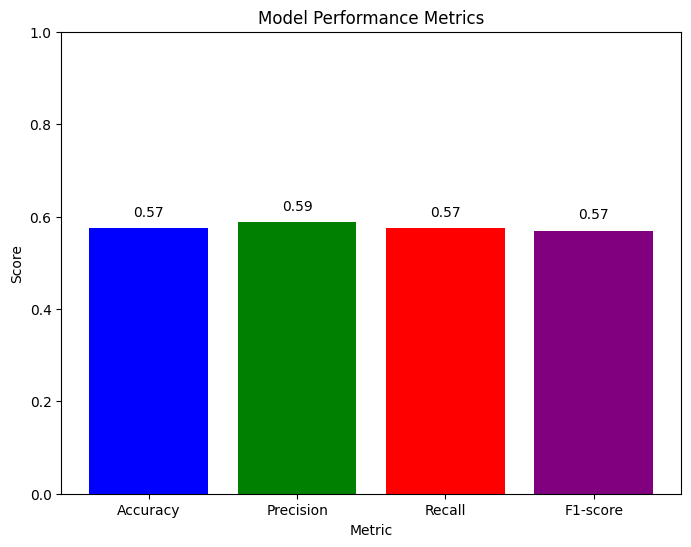

In [ ]:
# Data metrik
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

# Membuat bar chart
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.title('Model Performance Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim([0, 1])  # Mengatur batas sumbu y antara 0 dan 1

# Menambahkan label nilai di atas setiap bar
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

plt.show()

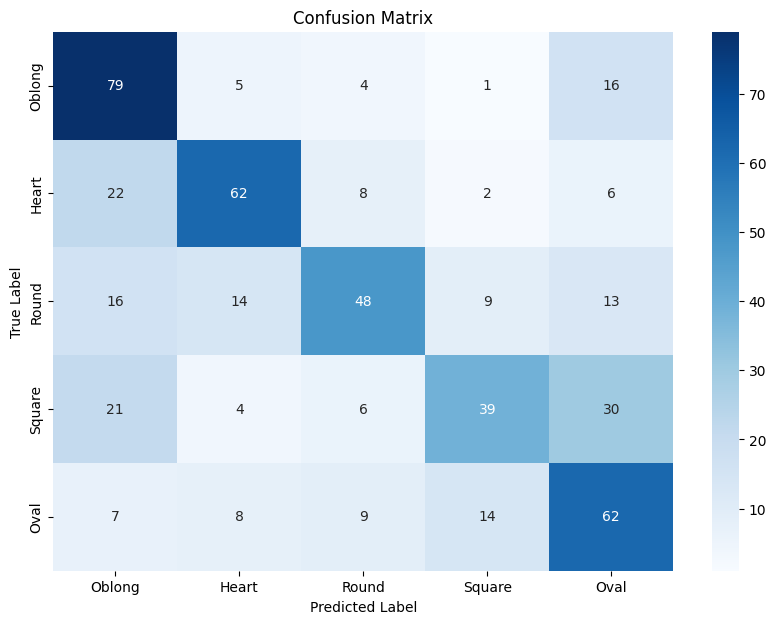

In [ ]:
# Buat dan tampilkan confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
history_2 = model.fit(
    train_ds,
    epochs=50,
    verbose=1,
    validation_data=validation_ds,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping_callback]
)

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - accuracy: 0.7212 - loss: 0.7415 - val_accuracy: 0.5644 - val_loss: 1.1940
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 181ms/step - accuracy: 0.7184 - loss: 0.7686 - val_accuracy: 0.5426 - val_loss: 1.2729
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 40s 172ms/step - accuracy: 0.7222 - loss: 0.7556 - val_accuracy: 0.5327 - val_loss: 1.2352
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 45s 203ms/step - accuracy: 0.7195 - loss: 0.7643 - val_accuracy: 0.5881 - val_loss: 1.1622
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 37s 173ms/step - accuracy: 0.7082 - loss: 0.7693 - val_accuracy: 0.5327 - val_loss: 1.2335
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 25s 201ms/step - accuracy: 0.7138 - loss: 0.7547 - val_accuracy: 0.5683 - val_loss: 1.2028
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 22s 173ms/step - accuracy: 0.7196 - loss: 0.7411 - val_accuracy: 0.5624 - val_loss: 1.1988
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.7184 - loss: 0